**Lab 4, Task 2  Sverdlyk Ivan, FB-51mp.**
В даній частині лабораторної роботи реалізовано генерацію зображень на архітектурі DCGAN. Датасет - Fashion MNIST.

Використовується пристрій: cuda


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 26.3MB/s]


Початок навчання.
Epoch [1/50] Loss D: 0.8975, Loss G: 5.5447
Epoch [2/50] Loss D: 0.5404, Loss G: 2.8212
Epoch [3/50] Loss D: 0.5765, Loss G: 2.7394
Epoch [4/50] Loss D: 0.4576, Loss G: 3.6077
Epoch [5/50] Loss D: 0.5637, Loss G: 4.9079
Epoch [6/50] Loss D: 0.7958, Loss G: 1.8898
Epoch [7/50] Loss D: 0.9545, Loss G: 3.6417
Epoch [8/50] Loss D: 1.1108, Loss G: 3.3197
Epoch [9/50] Loss D: 0.9038, Loss G: 1.6366
Epoch [10/50] Loss D: 0.8492, Loss G: 1.7652
Epoch [11/50] Loss D: 1.1503, Loss G: 1.4056
Epoch [12/50] Loss D: 1.1365, Loss G: 1.3436
Epoch [13/50] Loss D: 1.2014, Loss G: 1.6560
Epoch [14/50] Loss D: 1.0316, Loss G: 1.8809
Epoch [15/50] Loss D: 1.2318, Loss G: 1.3431
Epoch [16/50] Loss D: 1.0913, Loss G: 1.3603
Epoch [17/50] Loss D: 1.1193, Loss G: 1.4138
Epoch [18/50] Loss D: 1.1536, Loss G: 1.1976
Epoch [19/50] Loss D: 1.1515, Loss G: 1.2194
Epoch [20/50] Loss D: 1.3660, Loss G: 0.9470
Epoch [21/50] Loss D: 0.9848, Loss G: 1.5823
Epoch [22/50] Loss D: 1.1876, Loss G: 1.2014
E

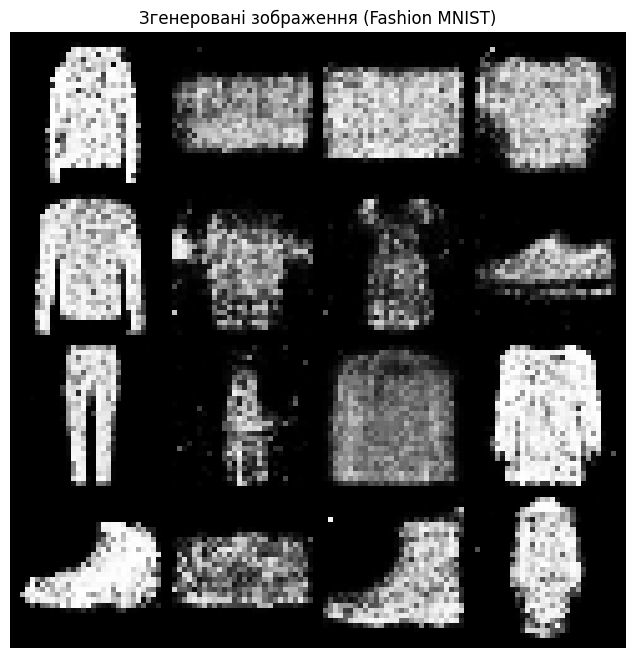

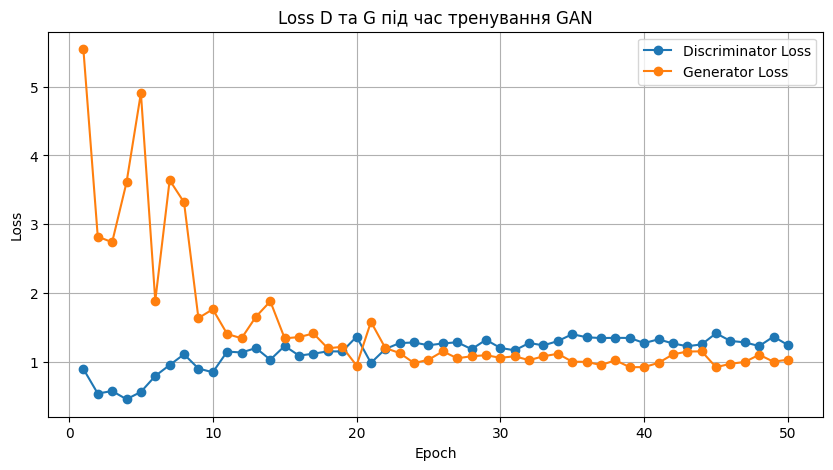

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Використовується пристрій: {device}")

# Гіперпараметри
BATCH_SIZE = 64
LR_G = 0.0001
LR_D = 0.0002
EPOCHS = 50
LATENT_DIM = 100
REAL_LABEL_SMOOTH = 0.9

# завантаження даних Fashion MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                            download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# генератор
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(LATENT_DIM, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        img = self.main(x)
        return img.view(-1, 1, 28, 28)

# дискримінатор
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=LR_G, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR_D, betas=(0.5, 0.999))

# збереження loss
losses_D = []
losses_G = []

# Цикл навчання
print("Початок навчання.")
for epoch in range(EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Мітки
        real_labels = torch.ones(batch_size, 1).to(device) * REAL_LABEL_SMOOTH
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Тренування дискримінатора
        optimizer_D.zero_grad()
        outputs_real = discriminator(real_imgs)
        d_loss_real = criterion(outputs_real, real_labels)

        z = torch.randn(batch_size, LATENT_DIM).to(device)
        fake_imgs = generator(z)
        outputs_fake = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Тренування генератора
        optimizer_G.zero_grad()
        outputs = discriminator(fake_imgs)
        g_loss = criterion(outputs, real_labels)  #
        g_loss.backward()
        optimizer_G.step()

    # Збереження loss після кожної епохи
    losses_D.append(d_loss.item())
    losses_G.append(g_loss.item())

    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")

print("Навчання завершено!")

# Візуалізація згенерованих зображень
def show_generated_images():
    generator.eval()
    with torch.no_grad():
        z = torch.randn(16, LATENT_DIM).to(device)
        generated = generator(z).cpu()
        plt.figure(figsize=(8,8))
        grid_img = torchvision.utils.make_grid(generated, nrow=4, normalize=True)
        plt.imshow(grid_img.permute(1,2,0), cmap='gray')
        plt.title("Згенеровані зображення (Fashion MNIST)")
        plt.axis('off')
        plt.show()

show_generated_images()

# Loss
plt.figure(figsize=(10,5))
plt.plot(range(1,EPOCHS+1), losses_D, label="Discriminator Loss", marker='o')
plt.plot(range(1,EPOCHS+1), losses_G, label="Generator Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss D та G під час тренування GAN")
plt.legend()
plt.grid(True)
plt.show()
